## Installing dependencies:

In [384]:
!pip install fredapi statsmodels --quiet

## Suppressing Warnings:

In [386]:
import warnings
warnings.filterwarnings("ignore")

## Importing Libraries:

In [388]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fredapi import Fred
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.irf import IRAnalysis

## Defining my own Augmented Dickey-Fuller Test Function:

In [390]:
def adftest(series, name):
    print(f"Result of the Augmented Dickey Fuller Test on the series {name}.")
    print("**" * 40)
    result = adfuller(series, maxlag = None, autolag = "aic")
    adf_test_statistic = result[0]
    p_value = result[1]
    used_lag = result[2]
    number_of_observations = result[3]
    critical_values = result[4]
    # Display the results
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Used Lag: {result[2]}")
    print(f"Number of Observations: {result[3]}")
    print(f"Critical Values: {result[4]}")
    if p_value < 0.05:
        print("Reject the null hypothesis: The series is STATIONARY.")
        print("It does not have a unit root (I(0))")
        print("==" * 40)
    else:
        print("Fail to reject the null hypothesis: The series has a unit root (NON-STATIONARY).")
        print("It has a unit root (I(1))")
        print("==" * 40)

## Defining my own KPSS test function:

In [392]:
def kpsstest(series, name, regression):
    print(f"Result of the Kwiatkowski-Phillip-Schmidt-Shin Test on the series {name}.")
    if regression == "ct":
        print("Checking for stationarity of the series around a deterministic trend.")
    else:
        print("Checking for stationarity around a mean.")
    print("**" * 40)
    result = kpss(series, regression = regression)
    kpss_statistic = result[0]
    p_value = result[1]
    lags_used = result[2]
    critical_values = result[3]
    print(f"KPSS Statistic: {kpss_statistic}")
    print(f"p-value: {p_value}")
    print(f"Lags used: {lags_used}")
    print(f"Critical Values: {critical_values}")
    if p_value < 0.05:
        print("Reject the null hypothesis: The series is NON-STATIONARY.")
        print("==" * 40)
    else:
        print("Fail to reject the null hypothesis: The series is STATIONARY.")
        print("=="  * 40)

## Defining my own ACF-PACF plot generating functions:

In [394]:
def acfpacfplots(series, name):
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plot_acf(series, lags = 40, ax = plt.gca(), title = "Autocorrelation Function (ACF)")
    plt.subplot(122)
    plot_pacf(series, lags = 40, ax = plt.gca(), title = "Partial Autocorrelation Function (PACF)")
    plt.tight_layout()
    plt.show()

## FRED API credentials to access data:

In [396]:
fred_key = "70e784bbfbc7c5ed1554cd06e96b7925"
fred = Fred(api_key=fred_key)

## Fetching Trade Data from FRED and performing necessary transformations:
- We fetch the data first
- We rename the columns properly
- Drop NaN values
- Reframe each observation period
- Create a date column and set it as our index
- Resample data to Quaterly means
- Generate log transformations as required to study the J Curve effect theoretically. This step is also beneficial for scaling purposes.

In [398]:
lnexportsto = fred.get_series("EXPCA").to_frame()
lnimportsfrom = fred.get_series("IMPCA").to_frame()
lnexch = fred.get_series("CCUSSP01CAQ650N").to_frame()
lnusgdp = fred.get_series("GDP").to_frame()
lncagdp = fred.get_series("NGDPRSAXDCCAQ").to_frame()

lnexportsto.rename(columns={0: 'lnEXtoCA'}, inplace = True)
lnimportsfrom.rename(columns={0: 'lnIMfromCA'}, inplace=True)
lnexch.rename(columns={0: 'exch'}, inplace = True)
lnusgdp.rename(columns={0: 'lnusgdp'}, inplace = True)
lncagdp.rename(columns={0: 'lncagdp'}, inplace = True)

lnexportsto.dropna(inplace = True)
lnimportsfrom.dropna(inplace = True)
lnexch.dropna(inplace = True)
lnusgdp.dropna(inplace = True)
lncagdp.dropna(inplace = True)

lnexportsto = lnexportsto.loc["1994-01-01" : "2023-12-31"]
lnimportsfrom = lnimportsfrom.loc["1994-01-01" : "2023-12-31"]
lnexch = lnexch.loc["1994-01-01" : "2023-12-31"]
lnusgdp = lnusgdp.loc["1994-01-01" : "2023-12-31"]
lncagdp = lncagdp.loc["1994-01-01" : "2023-12-31"]

lnexportsto['Date'] = lnexportsto.index
lnimportsfrom['Date'] = lnimportsfrom.index
lnexch['Date'] = lnexch.index
lnusgdp['Date'] = lnusgdp.index
lncagdp['Date'] = lncagdp.index

lnexportsto.set_index('Date', inplace = True)
lnimportsfrom.set_index('Date', inplace = True)
lnexch.set_index('Date', inplace = True)
lnusgdp.set_index('Date', inplace = True)
lncagdp.set_index('Date', inplace = True)

lnexportsto = lnexportsto.resample('QE').mean()
lnimportsfrom = lnimportsfrom.resample('QE').mean()
lnexch = lnexch.resample('QE').mean()
lnusgdp = lnusgdp.resample('QE').mean()
lncagdp = lncagdp.resample('QE').mean()

lnexportsto["lnEXtoCA"] = np.log10(lnexportsto["lnEXtoCA"])
lnimportsfrom["lnIMfromCA"] = np.log10(lnimportsfrom["lnIMfromCA"])
lnexch["exch"] = np.log10(lnexch["exch"])
lnusgdp["lnusgdp"] = np.log10(lnusgdp["lnusgdp"])
lncagdp["lncagdp"] = np.log10(lncagdp["lncagdp"])

print(lncagdp.shape, lnusgdp.shape, lnexch.shape, lnexportsto.shape, lnimportsfrom.shape)

(120, 1) (120, 1) (120, 1) (120, 1) (120, 1)


## Calculating Trade Balance:

In [400]:
# create a series of difference of exports and exports (trade balance)
lntrbl = lnexportsto["lnEXtoCA"] - lnimportsfrom["lnIMfromCA"]

## Plotting each of the series:
- These plots will help visualise rising or falling mean values and volatility of variances.
- Such observations are easy red flags for non-stationary data.

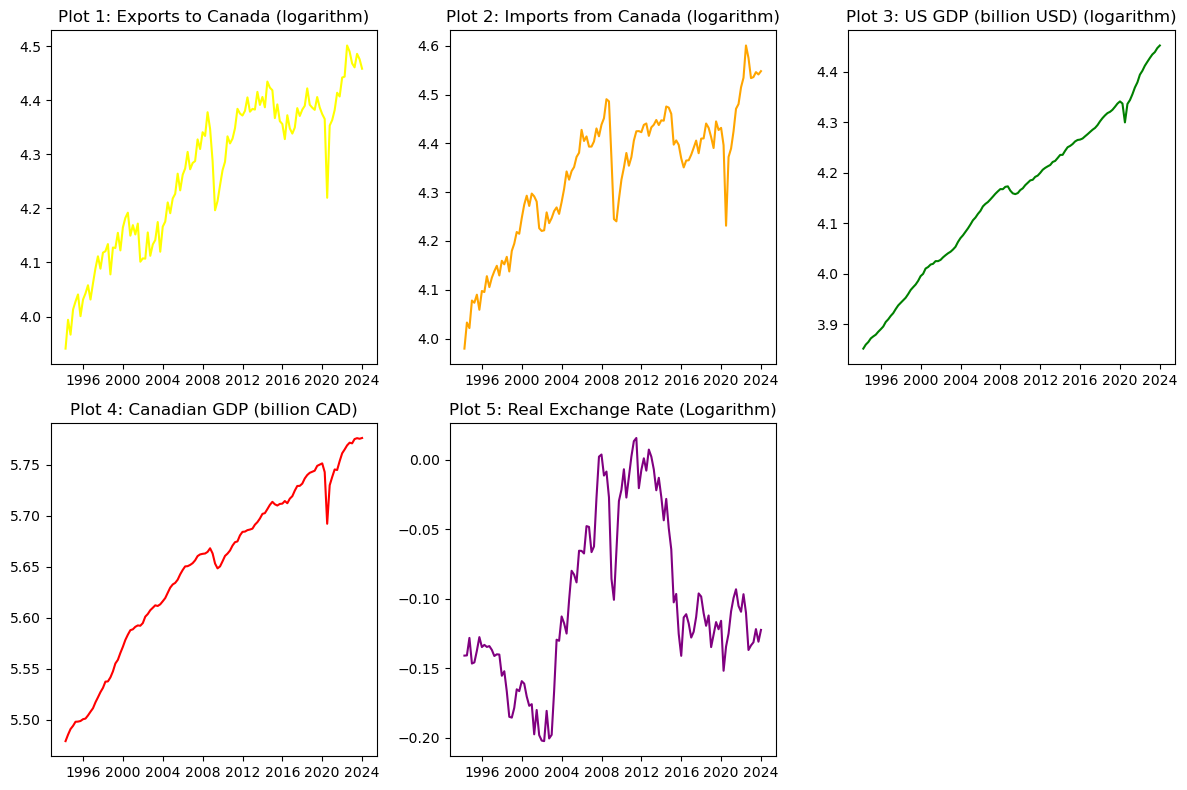

In [402]:
# create plots of each of the series at levels
x = lnusgdp.index
y1 = lnexportsto["lnEXtoCA"]
y2 = lnimportsfrom["lnIMfromCA"]
y3 = lnusgdp["lnusgdp"]
y4 = lncagdp["lncagdp"]
y5 = lnexch["exch"]
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()
axes[0].plot(x, y1, label = "lnEXtoCA", color = "yellow")
axes[0].set_title("Plot 1: Exports to Canada (logarithm)")
axes[1].plot(x, y2, label = "lnIMfromCA", color = "orange")
axes[1].set_title("Plot 2: Imports from Canada (logarithm)")
axes[2].plot(x, y3, label = "lnusgdp", color = "green")
axes[2].set_title("Plot 3: US GDP (billion USD) (logarithm)")
axes[3].plot(x, y4, label = "lncagdp", color = "red")
axes[3].set_title("Plot 4: Canadian GDP (billion CAD)")
axes[4].plot(x, y5, label = "exch", color = "purple")
axes[4].set_title("Plot 5: Real Exchange Rate (Logarithm)")
axes[5].axis("off")
plt.tight_layout()
plt.show()

## Augmented Dickey-Fuller test is performed on log transformed series at levels. The summary statistics fails the null hypothesis of stationarity.

In [404]:
# we run the ADF test on each of the series at levels
# necessary summary statistics are shown
adftest(lnexportsto["lnEXtoCA"], name = "lnexportsto")
adftest(lnimportsfrom["lnIMfromCA"], name = "lnimportsfrom")
adftest(lnusgdp["lnusgdp"], name = "lnusgdp")
adftest(lncagdp["lncagdp"], name = "lncagdp")
adftest(lnexch["exch"], name = "lnexch")

Result of the Augmented Dickey Fuller Test on the series lnexportsto.
********************************************************************************
ADF Statistic: -1.3897311869677011
p-value: 0.587189095465281
Used Lag: 4
Number of Observations: 115
Critical Values: {'1%': -3.4885349695076844, '5%': -2.887019521656941, '10%': -2.5803597920604915}
Fail to reject the null hypothesis: The series has a unit root (NON-STATIONARY).
It has a unit root (I(1))
Result of the Augmented Dickey Fuller Test on the series lnimportsfrom.
********************************************************************************
ADF Statistic: -2.2764732707105004
p-value: 0.1796681036325249
Used Lag: 0
Number of Observations: 119
Critical Values: {'1%': -3.4865346059036564, '5%': -2.8861509858476264, '10%': -2.579896092790057}
Fail to reject the null hypothesis: The series has a unit root (NON-STATIONARY).
It has a unit root (I(1))
Result of the Augmented Dickey Fuller Test on the series lnusgdp.
*************

## Differencing each series to perform ADF tests again:

In [406]:
# we convert each of the series to first differences
lnexportsto_d1 = lnexportsto.diff().dropna()
lnimportsfrom_d1 = lnimportsfrom.diff().dropna()
lnusgdp_d1 = lnusgdp.diff().dropna()
lncagdp_d1 = lncagdp.diff().dropna()
lnexch_d1 = lnexch.diff().dropna()

## Performing ADF tests on each differenced series to check for stationarity. After differencing, we can see that the summary statisics have confirmed each of our series to be stationary after differencing.

In [408]:

adftest(lnexportsto_d1["lnEXtoCA"], name = "lnexportsto_d1")
adftest(lnimportsfrom_d1["lnIMfromCA"], name = "lnimportsfrom_d1")
adftest(lnusgdp_d1["lnusgdp"], name = "lnusgdp_d1")
adftest(lncagdp_d1["lncagdp"], name = "lncagdp_d1")
adftest(lnexch_d1["exch"], name = "lnexch_d1")

Result of the Augmented Dickey Fuller Test on the series lnexportsto_d1.
********************************************************************************
ADF Statistic: -5.3534439833461995
p-value: 4.2394976841157e-06
Used Lag: 3
Number of Observations: 115
Critical Values: {'1%': -3.4885349695076844, '5%': -2.887019521656941, '10%': -2.5803597920604915}
Reject the null hypothesis: The series is STATIONARY.
It does not have a unit root (I(0))
Result of the Augmented Dickey Fuller Test on the series lnimportsfrom_d1.
********************************************************************************
ADF Statistic: -11.084965688348092
p-value: 4.219257409940446e-20
Used Lag: 0
Number of Observations: 118
Critical Values: {'1%': -3.4870216863700767, '5%': -2.8863625166643136, '10%': -2.580009026141913}
Reject the null hypothesis: The series is STATIONARY.
It does not have a unit root (I(0))
Result of the Augmented Dickey Fuller Test on the series lnusgdp_d1.
*********************************

## ACF and PACF analysis to determine the nautre of each series at a glance:

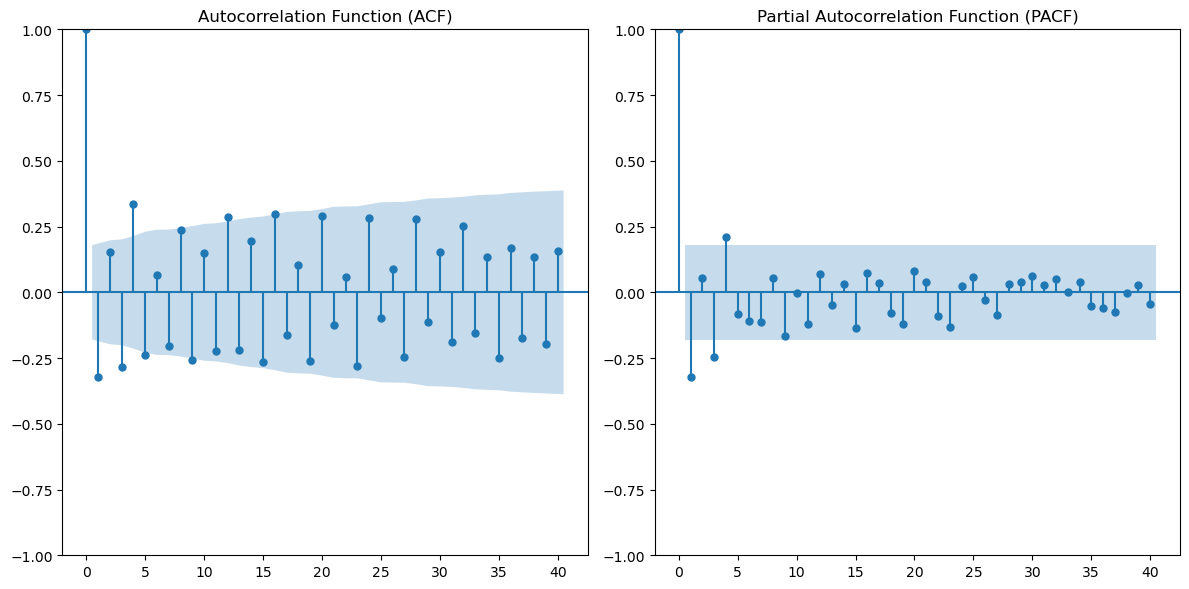

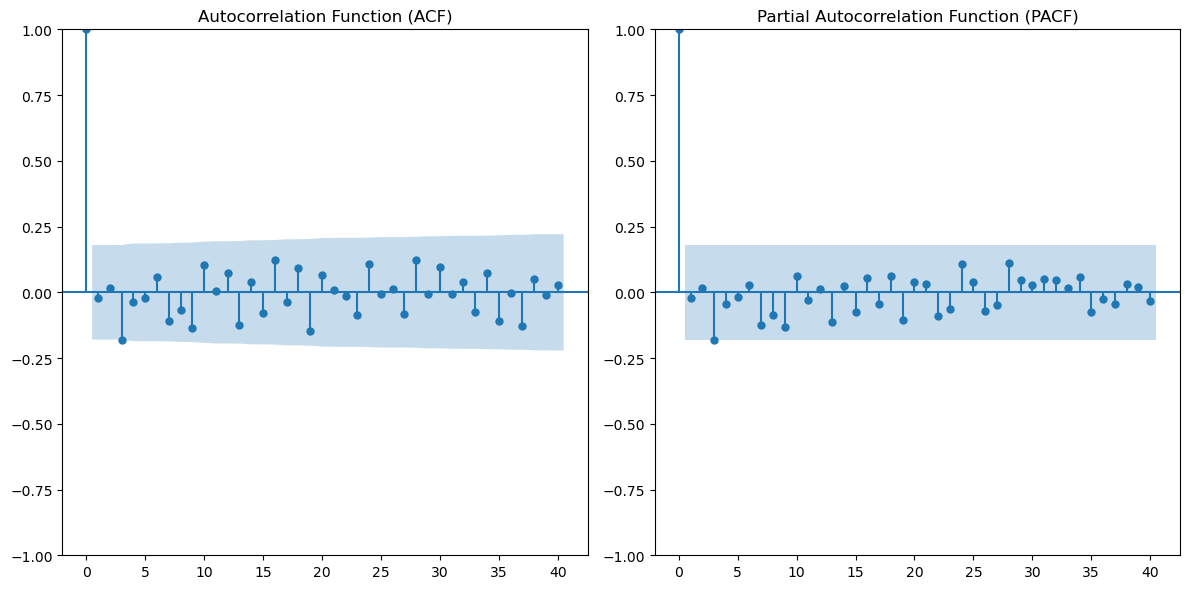

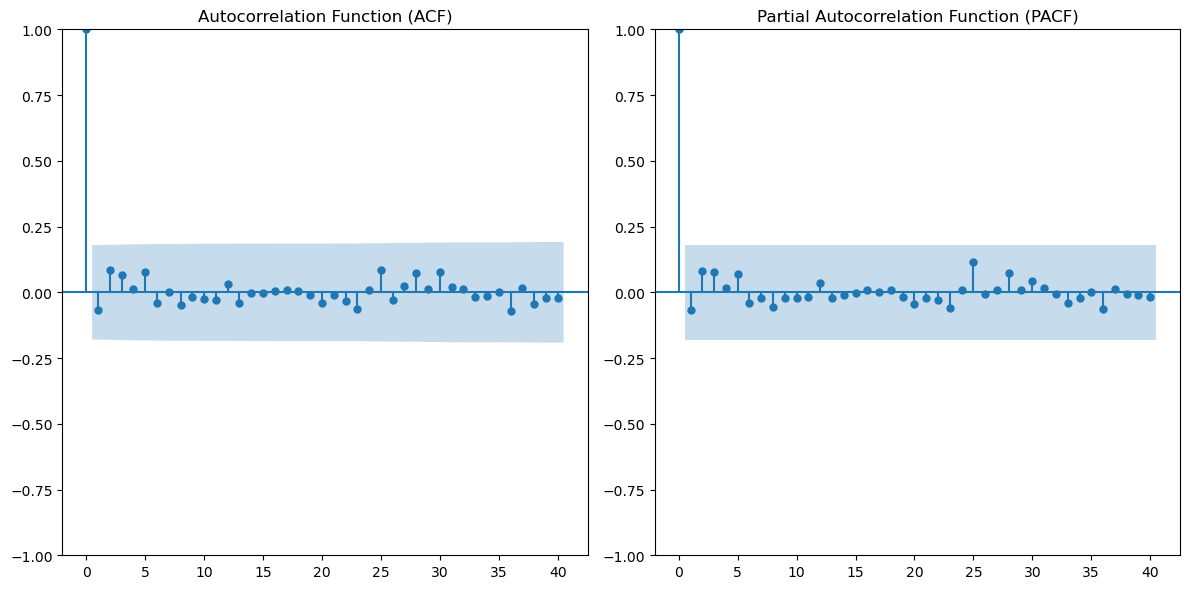

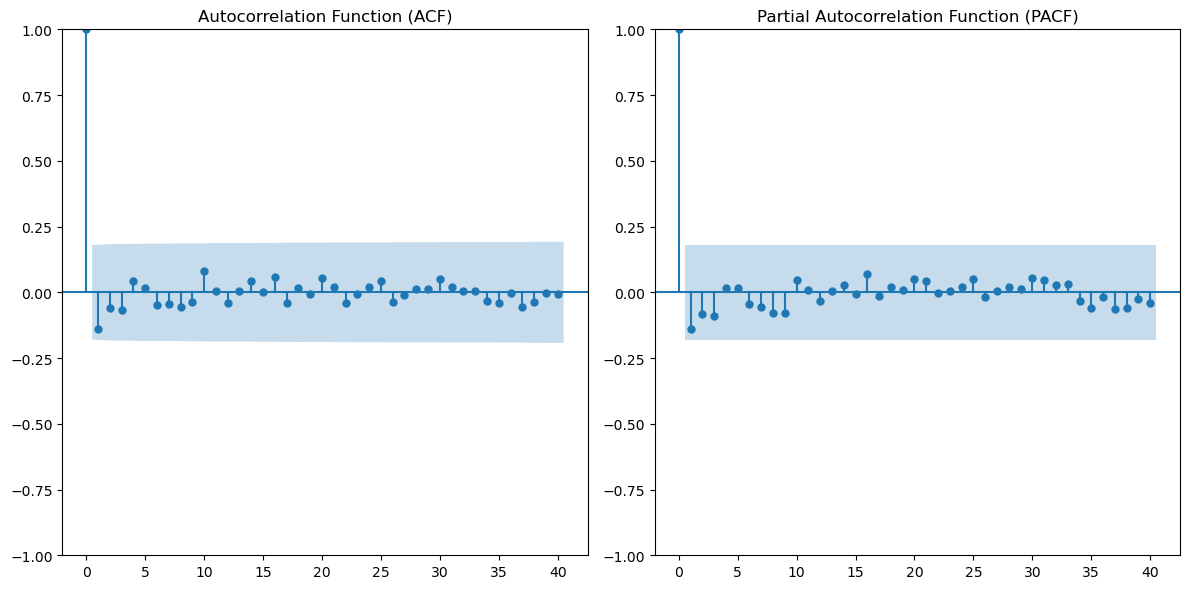

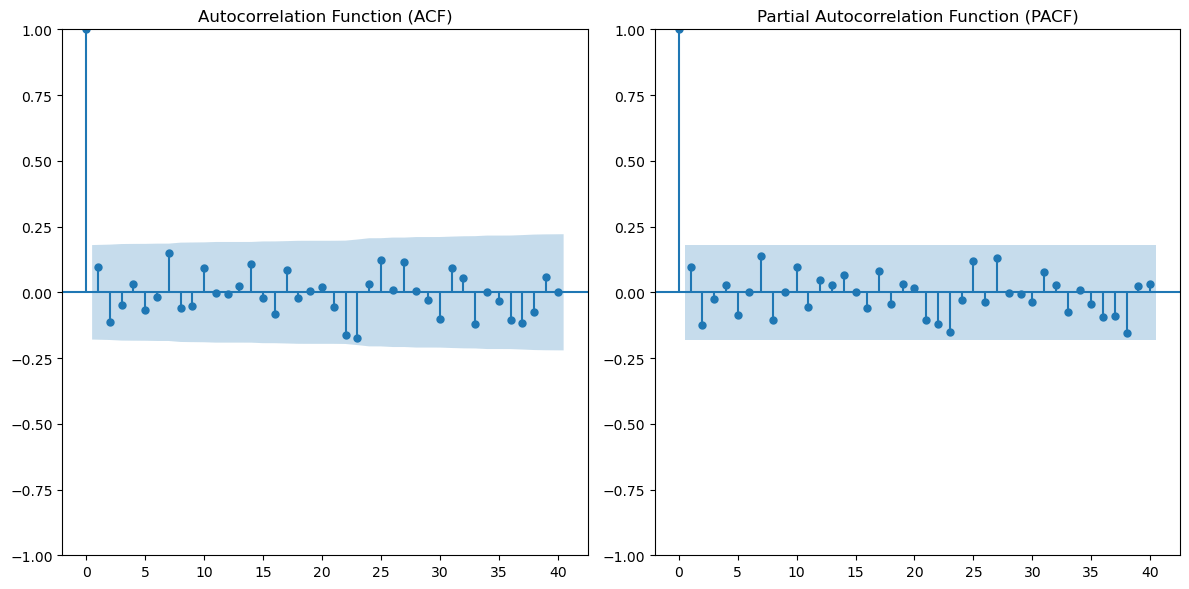

In [410]:
acfpacfplots(lnexportsto_d1["lnEXtoCA"], name = "lnexportsto_d1")
acfpacfplots(lnimportsfrom_d1["lnIMfromCA"], name = "lnimportsfrom_d1")
acfpacfplots(lnusgdp_d1["lnusgdp"], name = "lnusgdp_d1")
acfpacfplots(lncagdp_d1["lncagdp"], name = "lncagdp_d1")
acfpacfplots(lnexch_d1["exch"], name = "exch")

## The KPSS test results have been left out. The results confirm the findings of the ADF tests.

In [412]:
# kpsstest(lnexportsto["lnEXtoCA"], regression = "c", name = "lnexportsto")
# kpsstest(lnimportsfrom["lnIMfromCA"], regression = "c", name = "lnimportsfrom")
# kpsstest(lnusgdp["lnusgdp"], regression = "c", name = "lnusgdp")
# kpsstest(lncagdp["lncagdp"], regression = "c", name = "lncagdp")
# kpsstest(lnexch["exch"], regression = "c", name = "exch")

In [413]:
# kpsstest(lnexportsto_d1["lnEXtoCA"], regression = "c", name = "lnexportsto_d1")
# kpsstest(lnimportsfrom_d1["lnIMfromCA"], regression = "c", name = "lnimportsfrom_d1")
# kpsstest(lnusgdp_d1["lnusgdp"], regression = "c", name = "lnusgdp_d1")
# kpsstest(lncagdp_d1["lncagdp"], regression = "c", name = "lncagdp_d1")
# kpsstest(lnexch_d1["exch"], regression = "c", name = "lnexch_d1")

In [414]:
# kpsstest(lnexportsto["lnEXtoCA"], regression = "ct", name = "lnexportsto")
# kpsstest(lnimportsfrom["lnIMfromCA"], regression = "ct", name = "lnimportsfrom")
# kpsstest(lnusgdp["lnusgdp"], regression = "ct", name = "lnusgdp")
# kpsstest(lncagdp["lncagdp"], regression = "ct", name = "lncagdp")
# kpsstest(lnexch["lnexch"], regression = "ct", name = "lnexch")

In [415]:
# kpsstest(lnexportsto_d1["lnEXtoCA"], regression = "ct", name = "lnexportsto_d1")
# kpsstest(lnimportsfrom_d1["lnIMfromCA"], regression = "ct", name = "lnimportsfrom_d1")
# kpsstest(lnusgdp_d1["lnusgdp"], regression = "ct", name = "lnusgdp_d1")
# kpsstest(lncagdp_d1["lncagdp"], regression = "ct", name = "lncagdp_d1")
# kpsstest(lnexch_d1["lnexch"], regression = "ct", name = "lnexch_d1")

## Plotting our differenced series to check for stationarity visually:

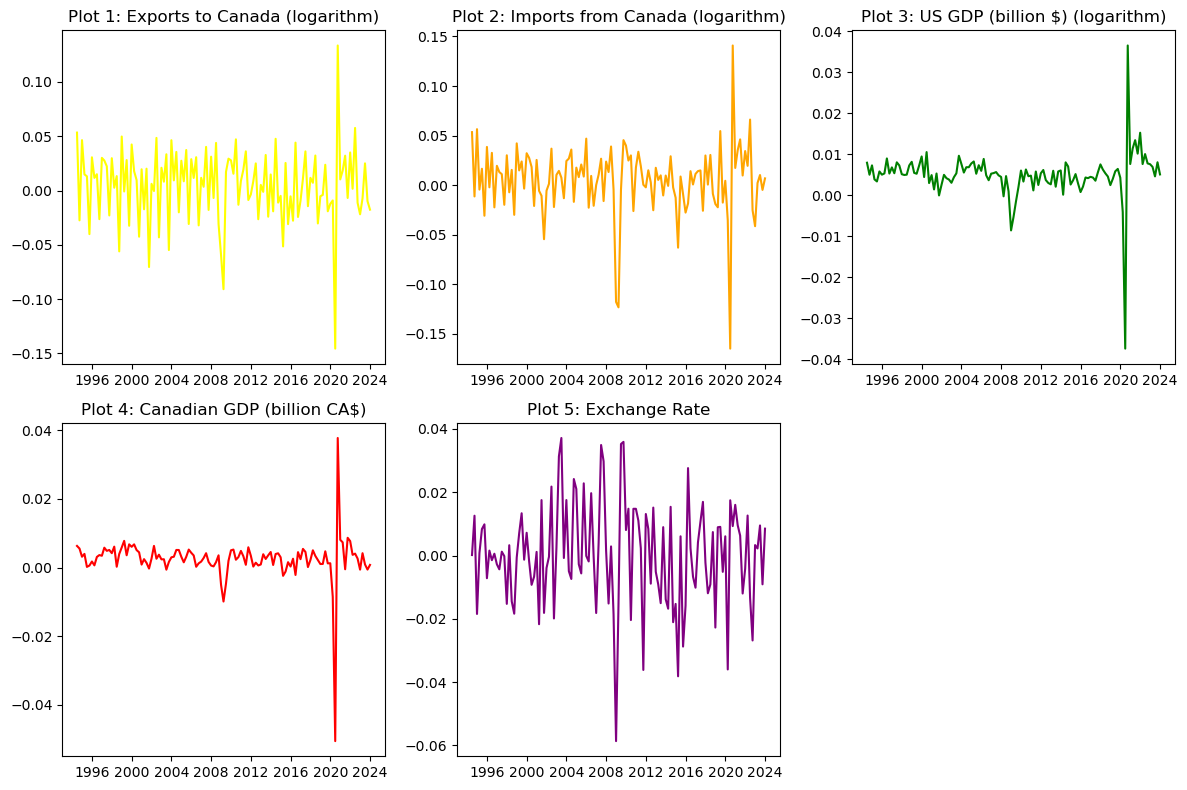

In [417]:
x = lncagdp_d1.index
y1 = lnexportsto_d1["lnEXtoCA"]
y2 = lnimportsfrom_d1["lnIMfromCA"]
y3 = lnusgdp_d1["lnusgdp"]
y4 = lncagdp_d1["lncagdp"]
y5 = lnexch_d1["exch"]
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()
axes[0].plot(x, y1, label='lnEXtoCA(x)', color='yellow')
axes[0].set_title('Plot 1: Exports to Canada (logarithm)')
axes[1].plot(x, y2, label='lnIMfromCA', color='orange')
axes[1].set_title('Plot 2: Imports from Canada (logarithm)')
axes[2].plot(x, y3, label='lnusgdp', color='green')
axes[2].set_title('Plot 3: US GDP (billion $) (logarithm)')
axes[3].plot(x, y4, label='lncagdp', color='red')
axes[3].set_title('Plot 4: Canadian GDP (billion CA$)')
axes[4].plot(x, y5, label = 'exch', color='purple')
axes[4].set_title('Plot 5: Exchange Rate')
axes[5].axis('off')
plt.tight_layout()
plt.show()

## Generating our VAR model for an Impulse Response Analysis:

In [419]:
lntrbl = lnexportsto["lnEXtoCA"] - lnimportsfrom["lnIMfromCA"]
var_data = pd.concat([lntrbl, lnexch["exch"], lnusgdp["lnusgdp"], lncagdp["lncagdp"]], axis = 1)
var_data.rename(columns = {0: 'lntrbl', 1: 'lnexch'}, inplace=True)
var_data.dropna(inplace = True)

## Fitting the VAR model with proper lags:

In [421]:
model = VAR(var_data)
lag_order = model.select_order(maxlags = 4).aic
print(f"Optimal lag length based on AIC: {lag_order}")

Optimal lag length based on AIC: 4


## Model Summary and ANOVA table:

In [423]:
var_model = model.fit(lag_order)
print(var_model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 29, Jan, 2025
Time:                     04:54:49
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -37.0138
Nobs:                     116.000    HQIC:                  -37.9727
Log likelihood:           1650.03    FPE:                1.68960e-17
AIC:                     -38.6280    Det(Omega_mle):     9.77707e-18
--------------------------------------------------------------------
Results for equation lntrbl
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.798802         0.610609            1.308           0.191
L1.lntrbl          0.660758         0.096784            6.827           0.000
L1.exch           -0.297093         0.086954           -3.417          

## Response of trade balance to a unit standard deviation shock to exchange rate:

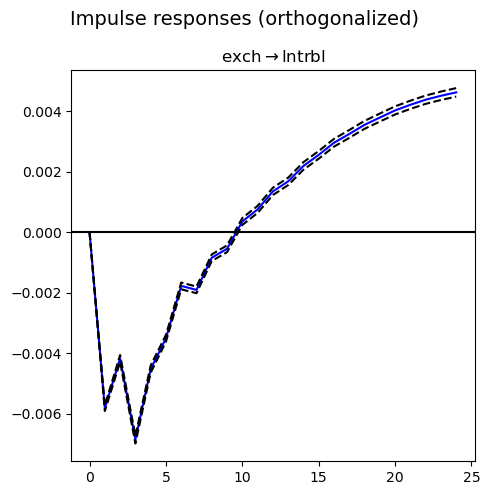

In [425]:
irf = var_model.irf(24)
irf.plot(impulse = "exch", response = "lntrbl", figsize = (5, 5), signif = 0.95, orth = True)
plt.tight_layout()

## The Marshall-Lerner Condition has been verified to hold true for US-Canada tradeflow in the period under consideration, since a typical J-Curve pattern is generated.